In [1]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.datasets import load_diabetes
from sklearn.inspection import PartialDependenceDisplay
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import numpy as np

pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.5f}'.format

In [2]:
import sys
import logging
import datetime

nblog = open("./logs/catboost_pdp_shap_"+str(datetime.datetime.now())+".log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [3]:
%%time
df_localness = pd.read_csv('./data/food_localness_final_oct.csv')
print('unique orders:',df_localness.shape[0])
print('unique accounts:',df_localness.account_id.unique().shape[0])
df_localness.head(2)

unique orders: 2767286
unique accounts: 555121
CPU times: user 21.3 s, sys: 11 s, total: 32.3 s
Wall time: 34.5 s


account_id    order_id  order_date           order_time  vendor_id         vendor_name main_cuisine vertical  delivery_fee_amount_lc  service_fee_amount_lc  basket_amount_lc is_incentive_applied  incentive_amount_lc       pickup_id  customer_lon  customer_lat  vendor_lon  vendor_lat  order_time_hour  delivery_duration  total_duration     node_id  nearest_dist1  poi1 n_vertical  n_vendor_id n_main_cuisine         n_vendor_name  n_vendor_lon  n_vendor_lat  vendor_index  pandana_distance_realdist  pandana_localness    speed isweekend  price_per_item                   customer_loc_id  entropy_0.5km  restaurant_count_0.5km  entropy_1km  poi_count_1km  entropy_2km  poi_count_2km  entropy_3km  poi_count_3km  entropy_4km  poi_count_4km  entropy_5km  poi_count_5km  restaurant_count_0.5_1km  restaurant_count_1_2km  restaurant_count_2_3km  restaurant_count_3_4km  restaurant_count_4_5km  estimated_rent  compensation  discounted delivery  free delivery     gem  item discount  menu discount  \
0  7051337     1305576462  2023-10-10  2023-10-10 15:30:22  50868      SHAGHF, Jumeirah 3  coffee       food    0.00000                 1.73000                57.75000           True                10.00000             249162013.00000 55.21388      25.15585      55.23119    25.18903     15               17                 27              7584090309 0.65435         840   food       697762       coffee         Awaken Cafe, Al Wasl 55.21303      25.15146       840          4.61510                    0.14179            10.25355  No       30.06471         55.21387725.155851               0.00000        0.00000                 0.47137      21.00000       0.65855      105.00000      0.66518      198.00000      0.69070      296.00000      0.70457      582.00000      21.00000                  84.00000                93.00000                98.00000                286.00000               90.44289        0.00000       0.00000              0.00000        0.00000 0.00000        0.00000          
1  7051337     1313167366  2023-10-16  2023-10-16 16:43:34  50868      SHAGHF, Jumeirah 3  coffee       food    7.50000                 0.90000                26.25000           True                10.00000             250948408.00000 55.21389      25.15572      55.23119    25.18903     16               13                 31              7584090309 0.65435         840   food       697762       coffee         Awaken Cafe, Al Wasl 55.21303      25.15146       840          4.61510                    0.14179            8.93051   No       30.06471         55.213885121047525.1557155663109 0.00000        0.00000                 0.47137      21.00000       0.65855      105.00000      0.66603      197.00000      0.69169      295.00000      0.70585      587.00000      21.00000                  84.00000                92.00000                98.00000                292.00000               90.65273        0.00000       0.00000              0.00000        0.00000 0.00000        0.00000          

   voucher wallet incentives_type incentive_delivery incentive_menu_discount incentive_voucher_wallet     rating n_rating  total_orders  consistency  
0 10.00000         voucher wallet  No                 No                      Yes                      1.Amazing  5.None   58           0.85783       
1 10.00000         voucher wallet  No                 No                      Yes                      1.Amazing  5.None   58           0.85783

In [4]:
# df_localness.incentive_voucher_wallet.value_counts()

In [4]:
df_features = df_localness[['basket_amount_lc','price_per_item','order_time_hour','total_duration',
                            'estimated_rent', 'entropy_0.5km','entropy_2km', 'entropy_5km', 
                            'incentive_amount_lc','incentive_delivery','incentive_menu_discount', 
                            'incentive_voucher_wallet', 'main_cuisine',
                             'isweekend', 'consistency', 'total_orders', 'rating','n_rating',
                            'restaurant_count_0.5km', 'restaurant_count_0.5_1km','restaurant_count_1_2km',
                            'restaurant_count_2_3km','restaurant_count_3_4km','restaurant_count_4_5km']]

categorical_list = ['isweekend','main_cuisine','incentive_delivery','incentive_menu_discount',
                    'incentive_voucher_wallet','rating','n_rating']

In [5]:
%%time
# check VIF
df_cor = df_features.corr()
pd.DataFrame(np.linalg.inv(df_features.corr().values), index = df_cor.index, columns=df_cor.columns)

CPU times: user 3.04 s, sys: 1.35 s, total: 4.39 s
Wall time: 4.42 s


basket_amount_lc  price_per_item  order_time_hour  total_duration  estimated_rent  entropy_0.5km  entropy_2km  entropy_5km  incentive_amount_lc  consistency  total_orders  restaurant_count_0.5km  restaurant_count_0.5_1km  restaurant_count_1_2km  restaurant_count_2_3km  restaurant_count_3_4km  restaurant_count_4_5km
basket_amount_lc         1.13138           -0.16907        -0.04553         -0.22255        -0.06888        0.06480        0.00216      -0.02384     -0.16175             -0.02400     0.03651       0.00188                 0.01098                   0.00685                 0.01711                 0.01784                 0.00709                
price_per_item           -0.16907          1.08888         -0.02394         -0.02361        -0.06228        -0.00914       -0.01237     -0.01432     -0.17826             -0.08212     -0.04198      -0.00080                0.00111                   -0.00296                0.00484                 0.00707                 -0.00502               
order_time_hour          -0.04553          -0.02394        1.01500          -0.06514        0.04488         0.03042        -0.00672     -0.02779     -0.00369             -0.00610     0.03192       -0.00255                -0.00274                  0.01577                 0.01431                 0.02257                 0.01865                
total_duration           -0.22255          -0.02361        -0.06514         1.09150         -0.08904        -0.04147       0.05692      0.10289      -0.08706             0.00427      0.02493       0.02856                 -0.01028                  -0.02135                -0.03551                -0.02966                -0.03116               
estimated_rent           -0.06888          -0.06228        0.04488          -0.08904        1.34858         -0.15935       0.28129      -0.20525     -0.00133             0.00465      -0.02217      0.04715                 -0.11294                  -0.42966                -0.16360                -0.00678                -0.18485               
entropy_0.5km            0.06480           -0.00914        0.03042          -0.04147        -0.15935        2.61585        -0.75108     0.27763      -0.04910             0.01042      0.04161       -1.27216                -0.35137                  -0.01331                -0.14887                -0.27376                -0.07309               
entropy_2km              0.00216           -0.01237        -0.00672         0.05692         0.28129         -0.75108       2.62908      -1.03772     -0.00044             -0.02981     -0.00463      0.18343                 -0.13032                  -0.72631                -0.25739                -0.26811                0.07791                
entropy_5km              -0.02384          -0.01432        -0.02779         0.10289         -0.20525        0.27763        -1.03772     1.86702      -0.00528             -0.03699     -0.06169      -0.15823                -0.04449                  0.05253                 -0.15289                -0.08086                -0.37561               
incentive_amount_lc      -0.16175          -0.17826        -0.00369         -0.08706        -0.00133        -0.04910       -0.00044     -0.00528     1.08608              -0.01745     0.03778       -0.01376                -0.00685                  -0.00344                0.00853                 -0.00369                0.00570                
consistency              -0.02400          -0.08212        -0.00610         0.00427         0.00465         0.01042        -0.02981     -0.03699     -0.01745             1.04111      -0.17073      0.00368                 0.02241                   0.01937                 0.01188                 0.02495                 0.00832                
total_orders             0.03651           -0.04198        0.03192          0.02493         -0.02217        0.04161        -0.00463     -0.06169     0.03778              -0.17073     1.04012       -0.00211                0.00911                   -0.021

# Feature engineering

In [6]:
%%time

X = df_features
y = df_localness.pandana_localness

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

# X_train.dtypes

import catboost as cb

train_dataset = cb.Pool(X_train, y_train, cat_features=categorical_list)
test_dataset = cb.Pool(X_test, y_test, cat_features=categorical_list)

CPU times: user 5.36 s, sys: 781 ms, total: 6.14 s
Wall time: 4.49 s


# Training

In [8]:
# %%time
# # ~takes 9min
# print(datetime.datetime.now(),'*************** Start running CatBoostRegressor ***************')

# regressor = cb.CatBoostRegressor(custom_metric= ['R2', 'RMSE'], early_stopping_rounds=50)
# regressor.fit(train_dataset, eval_set = test_dataset)
# output_path = './output/current_catboost_' + str(datetime.datetime.now())
# regressor.save_model(output_path)

# print(datetime.datetime.now(),'*************** Done running CatBoostRegressor ***************')

2024-06-21 11:17:08.034619 *************** Start running CatBoostRegressor ***************
Learning rate set to 0.167101
0:	learn: 0.2958629	test: 0.2960304	best: 0.2960304 (0)	total: 350ms	remaining: 5m 49s
1:	learn: 0.2874569	test: 0.2876463	best: 0.2876463 (1)	total: 601ms	remaining: 4m 59s
2:	learn: 0.2807102	test: 0.2809085	best: 0.2809085 (2)	total: 766ms	remaining: 4m 14s
3:	learn: 0.2758086	test: 0.2760338	best: 0.2760338 (3)	total: 1.01s	remaining: 4m 10s
4:	learn: 0.2719262	test: 0.2721836	best: 0.2721836 (4)	total: 1.19s	remaining: 3m 57s
5:	learn: 0.2689577	test: 0.2691889	best: 0.2691889 (5)	total: 1.36s	remaining: 3m 45s
6:	learn: 0.2665195	test: 0.2667578	best: 0.2667578 (6)	total: 1.52s	remaining: 3m 35s
7:	learn: 0.2646925	test: 0.2649388	best: 0.2649388 (7)	total: 1.7s	remaining: 3m 30s
8:	learn: 0.2632429	test: 0.2634977	best: 0.2634977 (8)	total: 1.88s	remaining: 3m 26s
9:	learn: 0.2620034	test: 0.2622748	best: 0.2622748 (9)	total: 2.05s	remaining: 3m 22s
10:	learn:

In [7]:
# load the trained CatBoost model
regressor = cb.CatBoostRegressor()
regressor.load_model('./output/current_catboost_2024-06-21 11:21:08.397599')

# Model evaluation

In [8]:
%%time
import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error, r2_score

y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Best Model RMSE: %.3f' % rmse)

r2 = r2_score(y_test, y_pred)
print('Best Model R-squared: %.3f' % r2)
# RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred) )
# Best Model RMSE: ~0.216
# Best Model R-squared: ~0.507

Best Model RMSE: 0.216
Best Model R-squared: 0.507
CPU times: user 5.01 s, sys: 268 ms, total: 5.28 s
Wall time: 795 ms


# Feature importance
## 1. Impurity importance

2024-06-21 12:04:43.379234 *************** Done running feature importance ***************
CPU times: user 14.5 s, sys: 251 ms, total: 14.7 s
Wall time: 14.6 s


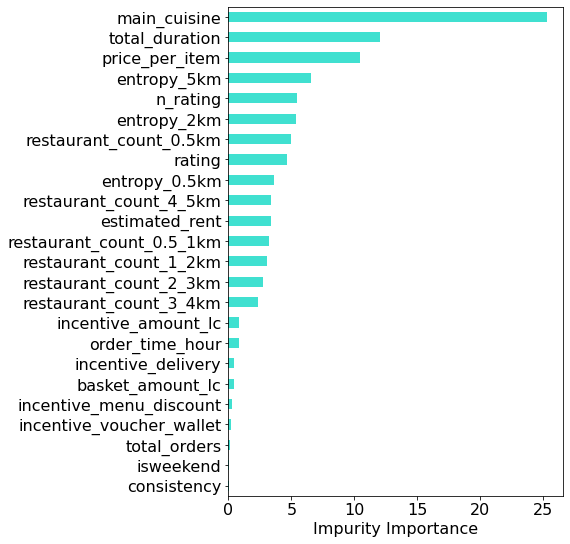

In [16]:
%%time
import matplotlib.pylab as plt
from matplotlib import pyplot

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1,figsize=(6,9))
df_feature_importance = pd.DataFrame({'feature_importance': regressor.get_feature_importance(train_dataset), 
              'feature_names': X_test.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)

df_feature_importance.sort_values(by=['feature_importance'], ascending=True).plot.barh(
    x='feature_names', y='feature_importance',align='center', color='turquoise',ax=ax)

# plt.xlabel("CatBoost Feature Importance")
plt.xlabel('Impurity Importance')
ax.get_legend().remove()
ax.set(ylabel=None)
plt.savefig('./output/feature_importance_impurity.pdf',bbox_inches="tight")

print(datetime.datetime.now(),'*************** Done running feature importance ***************')

## 2. Permutation importance

2024-06-21 12:01:35.985259 *************** Start running permutation_importance ***************
2024-06-21 12:04:28.548020 *************** Done running permutation_importance ***************
CPU times: user 24.7 s, sys: 7.19 s, total: 31.9 s
Wall time: 2min 52s


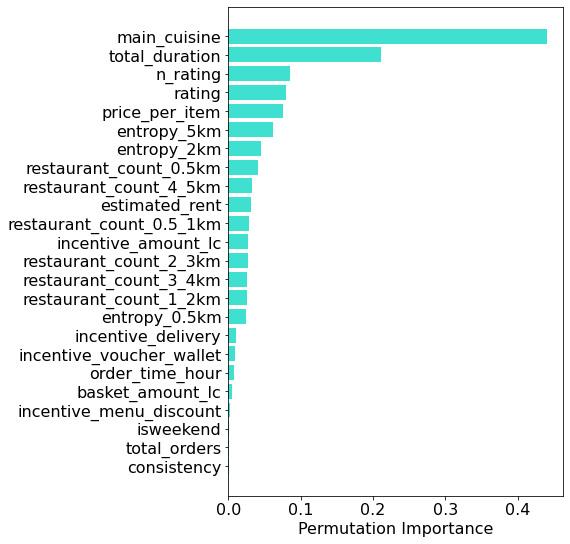

In [15]:
%%time
from sklearn.inspection import permutation_importance

print(datetime.datetime.now(),'*************** Start running permutation_importance ***************')
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1,figsize=(6,9))
perm_importance = permutation_importance(regressor, X_train, y_train, n_repeats=10, random_state=1066, n_jobs=4)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center',color='turquoise')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.xlabel('Permutation Importance')
plt.savefig('./output/feature_importance_permutation.pdf', bbox_inches='tight')
print(datetime.datetime.now(),'*************** Done running permutation_importance ***************')

# PDP

In [9]:
feature_list_continuous= ['order_time_hour','total_duration','estimated_rent', 'entropy_0.5km','entropy_2km', 
                          'entropy_5km', 'consistency', 'total_orders', 'incentive_amount_lc',
                          'restaurant_count_0.5km', 'restaurant_count_0.5_1km','restaurant_count_1_2km',
                          'restaurant_count_2_3km','restaurant_count_3_4km','restaurant_count_4_5km',
                          'basket_amount_lc','price_per_item'
                          ]
                          
print('number of continuous features:',len(feature_list_continuous))

feature_list_cat = ['isweekend','incentive_delivery', 'incentive_menu_discount', 'incentive_voucher_wallet',
                    'rating','n_rating'] #main_cusine has too many categories so use a different code to create PDP

number of continuous features: 17


## 1. PDP for continous features

An exmaple of PDP values

CPU times: user 46.1 ms, sys: 20.8 ms, total: 67 ms
Wall time: 799 ms


[{'grid_values': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
          17, 18, 19, 20, 21, 22, 23])],
  'values': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
          17, 18, 19, 20, 21, 22, 23])],
  'average': array([[0.32407825, 0.31904136, 0.31194531, 0.31194531, 0.313477  ,
          0.32583671, 0.33192414, 0.34920357, 0.37628237, 0.37628237,
          0.37621389, 0.37427446, 0.37769964, 0.38140267, 0.38091085,
          0.37928428, 0.37928428, 0.38049647, 0.39049679, 0.39636601,
          0.39595907, 0.37868896, 0.36160456, 0.33878991]])}]

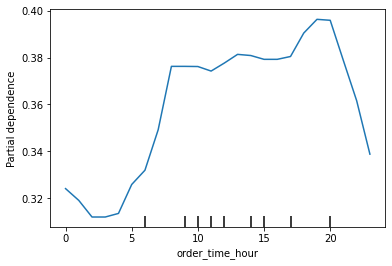

In [73]:
%%time
test = PartialDependenceDisplay.from_estimator(regressor, X[:1000], ['order_time_hour'],n_jobs = 6)
test.pd_results

In [ ]:
# %%time 
# I tried to plot all PDP all at once but seems to trigger memory errors
# print(datetime.datetime.now(),'*************** Start running PDP: feature_list_continuous ***************')

# plt.rcParams.update({'font.size': 14})
# fig, ax = plt.subplots(figsize=(12,15))
# plt.tight_layout()
# pdp_all_continuous = PartialDependenceDisplay.from_estimator(regressor, X, feature_list_continuous, n_jobs=8, ax=ax)
# plt.subplots_adjust(top=1.2)
# plt.savefig('./output/pdp_all_continuous.pdf', bbox_inches="tight")

# print(datetime.datetime.now(),'*************** Done running PDP: feature_list_continuous ***************')

In [87]:
# %%time 
# ~50min
# print(datetime.datetime.now(),'*************** Start running PDP: feature_list_continuous ***************')

# for feature_one in ['restaurant_count_0.5km', 'restaurant_count_0.5_1km','restaurant_count_1_2km',
#     'restaurant_count_2_3km','restaurant_count_3_4km','restaurant_count_4_5km','price_per_item','estimated_rent']:
#     print(datetime.datetime.now(), feature_one)
#     plt.rcParams.update({'font.size': 14})
#     fig, ax = plt.subplots(figsize=(5,5))
#     pdp_one = PartialDependenceDisplay.from_estimator(regressor, X, [feature_one],n_jobs = 6, ax=ax)
#     plt.savefig('./output/pdp_' + feature_one + '.pdf', bbox_inches="tight")

# print(datetime.datetime.now(),'*************** Done running PDP: feature_list_continuous ***************')

In [ ]:
%%time 
# ~5min per PDP graph
# using for loop, otherwise might occur memory errors
# PDP for continuous features and save the graph for each feature separately
print(datetime.datetime.now(),'*************** Start running PDP: feature_list_continuous ***************')

for feature_one in feature_list_continuous:
    print(datetime.datetime.now(), feature_one)
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(figsize=(5,5))
    pdp_one = PartialDependenceDisplay.from_estimator(regressor, X, [feature_one],n_jobs = 6, ax=ax)
    plt.savefig('./output/pdp_' + feature_one + '.pdf', bbox_inches="tight")

print(datetime.datetime.now(),'*************** Done running PDP: feature_list_continuous ***************')

2024-06-21 12:57:32.335984 *************** Start running PDP: feature_list_continuous ***************
2024-06-21 12:57:32.336195 order_time_hour
2024-06-21 12:58:25.896951 total_duration
2024-06-21 13:01:59.397958 estimated_rent
2024-06-21 13:05:34.697445 entropy_0.5km
2024-06-21 13:09:10.191662 entropy_2km
2024-06-21 13:12:46.970134 entropy_5km
2024-06-21 13:16:25.356383 consistency


## 2. PDP for categorical features 


2024-06-21 12:56:27.575255 *************** Start running PDP: feature_list_cat ***************
2024-06-21 12:56:27.575945 isweekend
2024-06-21 12:56:37.610236 incentive_delivery
2024-06-21 12:56:45.987347 incentive_menu_discount
2024-06-21 12:56:54.319982 incentive_voucher_wallet
2024-06-21 12:57:02.664280 rating
2024-06-21 12:57:17.296625 n_rating
2024-06-21 12:57:31.946798 *************** Done running PDP: feature_list_cat ***************
CPU times: user 6.37 s, sys: 6.03 s, total: 12.4 s
Wall time: 1min 4s


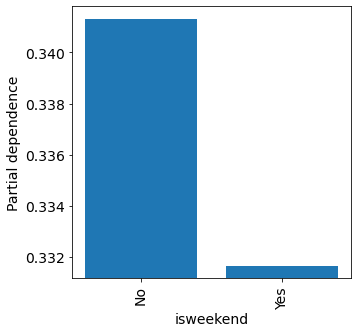

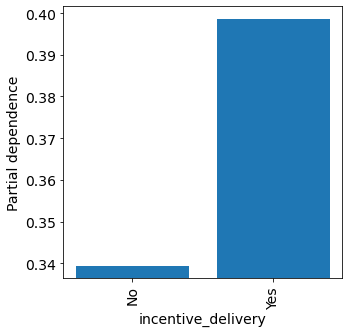

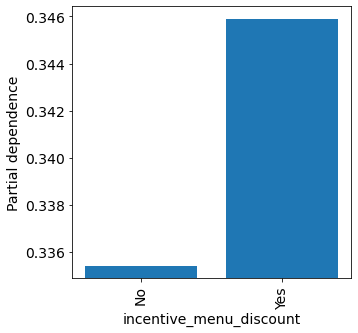

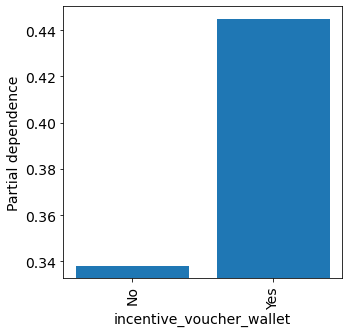

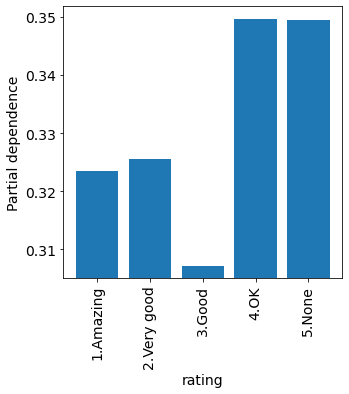

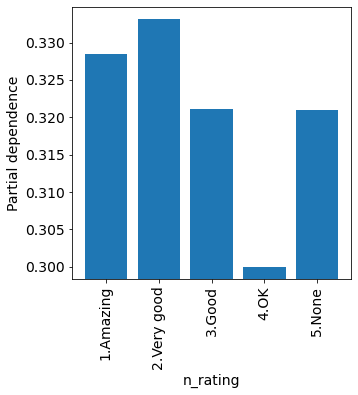

In [20]:
%%time 
# Wall time: 16min 29s
print(datetime.datetime.now(),'*************** Start running PDP: feature_list_cat ***************')

for feature_one in feature_list_cat:
    print(datetime.datetime.now(), feature_one)
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(figsize=(5,5))
    tree_disp_all = PartialDependenceDisplay.from_estimator(
        regressor, X, [feature_one], categorical_features=[feature_one], n_jobs=8 , ax=ax)
    plt.savefig('./output/pdp_'+feature_one+'.pdf',bbox_inches="tight")    

print(datetime.datetime.now(),'*************** Done running PDP: feature_list_cat ***************')

main_cusine is a huge categorical feature so create a customized graph

2024-06-21 12:06:12.492666 *************** Start running PDP: main_cusine ***************
2024-06-21 12:08:40.193999 *************** Done running PDP: main_cusine ***************
CPU times: user 2.45 s, sys: 3.31 s, total: 5.76 s
Wall time: 2min 27s


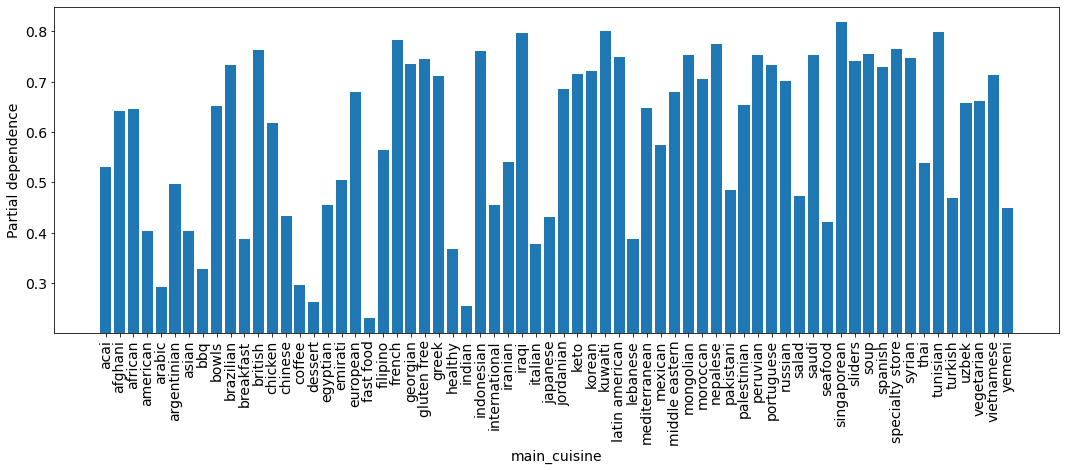

In [17]:
%%time 
# ~ 2min
print(datetime.datetime.now(),'*************** Start running PDP: main_cusine ***************')

feature_select = 'main_cuisine'

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(18,6))
pdp_main_cusine = PartialDependenceDisplay.from_estimator(
    regressor, X, [feature_select], categorical_features=[feature_select], n_jobs=8 ,ax=ax)
plt.savefig('./output/pdp_'+feature_select+'.pdf', bbox_inches="tight")

print(datetime.datetime.now(),'*************** Done running PDP: main_cusine ***************')

In [2]:
# print(pdp_main_cusine.bars_[0][0].get_height())
# print(pdp_main_cusine.bars_[0][0].get_x())

# SHAP
"When using CatBoost, you do not need to manually encode categorical features. CatBoost natively handles categorical features, making it unnecessary to apply encoding techniques like one-hot encoding or label encoding. Simply specify the categorical features in the model training process."

In [15]:
# # Using numerical encoding for categorical features so that SHAP beeswarm can color coded high and low values of categorical features
# X_shap = X.copy()
# X_shap.loc[X_shap.rating == '1.Amazing', 'rating'] = 5
# X_shap.loc[X_shap.rating == '2.Very good', 'rating'] = 4
# X_shap.loc[X_shap.rating == '3.Good', 'rating'] = 3
# X_shap.loc[X_shap.rating == '4.OK', 'rating'] = 2
# X_shap.loc[X_shap.rating == '5.None', 'rating'] = 1

# X_shap.loc[X_shap.n_rating == '1.Amazing', 'n_rating'] = 5
# X_shap.loc[X_shap.n_rating == '2.Very good', 'n_rating'] = 4
# X_shap.loc[X_shap.n_rating == '3.Good', 'n_rating'] = 3
# X_shap.loc[X_shap.n_rating == '4.OK', 'n_rating'] = 2
# X_shap.loc[X_shap.n_rating == '5.None', 'n_rating'] = 1


# X_shap.loc[X_shap.isweekend == 'Yes', 'isweekend'] = 1
# X_shap.loc[X_shap.isweekend == 'No', 'isweekend'] = 0

# X_shap.loc[X_shap.incentive_delivery == 'Yes', 'incentive_delivery'] = 1
# X_shap.loc[X_shap.incentive_delivery == 'No', 'incentive_delivery'] = 0

# X_shap.loc[X_shap.incentive_menu_discount == 'Yes', 'incentive_menu_discount'] = 1
# X_shap.loc[X_shap.incentive_menu_discount == 'No', 'incentive_menu_discount'] = 0

# X_shap.loc[X_shap.incentive_voucher_wallet == 'Yes', 'incentive_voucher_wallet'] = 1
# X_shap.loc[X_shap.incentive_voucher_wallet == 'No', 'incentive_voucher_wallet'] = 0
# print(X_shap.shape[0]) #2767286

In [122]:
# %%time
# #  ~4min
# import shap
# print(datetime.datetime.now(),'*************** Start running SHAP ***************')
# explainer = shap.TreeExplainer(regressor)
# shap_values = explainer(X_shap)
# print(datetime.datetime.now(),'*************** Done running SHAP ***************')

In [120]:
# # apply Label Encoding over categorical features
# # https://stackoverflow.com/questions/57285499/how-to-tell-the-shap-tree-explainer-and-shap-values-calculator-which-variables-a
# X_shap = X.copy()
# X_shap['rating'] = X_shap['rating'].astype('category')
# X_shap['rating'] = X_shap['rating'].cat.codes

# X_shap['n_rating'] = X_shap['n_rating'].astype('category')
# X_shap['n_rating'] = X_shap['n_rating'].cat.codes

# X_shap['isweekend'] = X_shap['isweekend'].astype('category')
# X_shap['isweekend'] = X_shap['isweekend'].cat.codes

# X_shap['incentive_delivery'] = X_shap['incentive_delivery'].astype('category')
# X_shap['incentive_delivery'] = X_shap['incentive_delivery'].cat.codes

# X_shap['incentive_menu_discount'] = X_shap['incentive_menu_discount'].astype('category')
# X_shap['incentive_menu_discount'] = X_shap['incentive_menu_discount'].cat.codes

# X_shap['incentive_voucher_wallet'] = X_shap['incentive_voucher_wallet'].astype('category')
# X_shap['incentive_voucher_wallet'] = X_shap['incentive_voucher_wallet'].cat.codes

# # X_shap['main_cuisine'] = X_shap['main_cuisine'].astype('category')
# # X_shap['main_cuisine'] = X_shap['main_cuisine'].cat.codes

# X_shap = X.copy()
# X_shap = pd.get_dummies(X_shap)
# X_shap

In [10]:
%%time
#  ~4min
import shap
print(datetime.datetime.now(),'*************** Start running SHAP ***************')
explainer = shap.TreeExplainer(regressor)
shap_values = explainer(X)
print(datetime.datetime.now(),'*************** Done running SHAP ***************')

2024-06-26 20:58:06.208938 *************** Start running SHAP ***************
2024-06-26 20:59:21.273846 *************** Done running SHAP ***************
CPU times: user 10min 53s, sys: 16.4 s, total: 11min 9s
Wall time: 1min 22s


In [11]:
print(df_localness.order_id.unique().shape[0])
df_localness.head(2)

2767286


account_id    order_id  order_date           order_time  vendor_id         vendor_name main_cuisine vertical  delivery_fee_amount_lc  service_fee_amount_lc  basket_amount_lc is_incentive_applied  incentive_amount_lc       pickup_id  customer_lon  customer_lat  vendor_lon  vendor_lat  order_time_hour  delivery_duration  total_duration     node_id  nearest_dist1  poi1 n_vertical  n_vendor_id n_main_cuisine         n_vendor_name  n_vendor_lon  n_vendor_lat  vendor_index  pandana_distance_realdist  pandana_localness    speed isweekend  price_per_item                   customer_loc_id  entropy_0.5km  restaurant_count_0.5km  entropy_1km  poi_count_1km  entropy_2km  poi_count_2km  entropy_3km  poi_count_3km  entropy_4km  poi_count_4km  entropy_5km  poi_count_5km  restaurant_count_0.5_1km  restaurant_count_1_2km  restaurant_count_2_3km  restaurant_count_3_4km  restaurant_count_4_5km  estimated_rent  compensation  discounted delivery  free delivery     gem  item discount  menu discount  \
0  7051337     1305576462  2023-10-10  2023-10-10 15:30:22  50868      SHAGHF, Jumeirah 3  coffee       food    0.00000                 1.73000                57.75000           True                10.00000             249162013.00000 55.21388      25.15585      55.23119    25.18903     15               17                 27              7584090309 0.65435         840   food       697762       coffee         Awaken Cafe, Al Wasl 55.21303      25.15146       840          4.61510                    0.14179            10.25355  No       30.06471         55.21387725.155851               0.00000        0.00000                 0.47137      21.00000       0.65855      105.00000      0.66518      198.00000      0.69070      296.00000      0.70457      582.00000      21.00000                  84.00000                93.00000                98.00000                286.00000               90.44289        0.00000       0.00000              0.00000        0.00000 0.00000        0.00000          
1  7051337     1313167366  2023-10-16  2023-10-16 16:43:34  50868      SHAGHF, Jumeirah 3  coffee       food    7.50000                 0.90000                26.25000           True                10.00000             250948408.00000 55.21389      25.15572      55.23119    25.18903     16               13                 31              7584090309 0.65435         840   food       697762       coffee         Awaken Cafe, Al Wasl 55.21303      25.15146       840          4.61510                    0.14179            8.93051   No       30.06471         55.213885121047525.1557155663109 0.00000        0.00000                 0.47137      21.00000       0.65855      105.00000      0.66603      197.00000      0.69169      295.00000      0.70585      587.00000      21.00000                  84.00000                92.00000                98.00000                292.00000               90.65273        0.00000       0.00000              0.00000        0.00000 0.00000        0.00000          

   voucher wallet incentives_type incentive_delivery incentive_menu_discount incentive_voucher_wallet     rating n_rating  total_orders  consistency  
0 10.00000         voucher wallet  No                 No                      Yes                      1.Amazing  5.None   58           0.85783       
1 10.00000         voucher wallet  No                 No                      Yes                      1.Amazing  5.None   58           0.85783

### save SHAP values

In [127]:
%%time
shaplist = ['shap_'+i for i in X.columns]
df_shape_values = pd.DataFrame(shap_values.values, columns=shaplist)

df_shape_values['account_id'] = df_localness['account_id']
df_shape_values['customer_lon'] = df_localness['customer_lon']
df_shape_values['customer_lat'] = df_localness['customer_lat']

df_shape_values['vendor_id'] = df_localness['vendor_id']
df_shape_values['vendor_lon'] = df_localness['vendor_lon']
df_shape_values['vendor_lat'] = df_localness['vendor_lat']

df_shape_values['order_id'] = df_localness['order_id']
first_column = df_shape_values.pop('order_id')
df_shape_values.insert(0, 'order_id', first_column)
# df_shape_values
df_shape_values.to_csv('./output/food_localness_final_oct_shap_values.csv',sep=',',index=False)
df_shape_values.head()

CPU times: user 1min 19s, sys: 1.27 s, total: 1min 21s
Wall time: 1min 23s


order_id  shap_basket_amount_lc  shap_price_per_item  shap_order_time_hour  shap_total_duration  shap_estimated_rent  shap_entropy_0.5km  shap_entropy_2km  shap_entropy_5km  shap_incentive_amount_lc  shap_incentive_delivery  shap_incentive_menu_discount  shap_incentive_voucher_wallet  shap_main_cuisine  shap_isweekend  shap_consistency  shap_total_orders  shap_rating  shap_n_rating  shap_restaurant_count_0.5km  shap_restaurant_count_0.5_1km  shap_restaurant_count_1_2km  shap_restaurant_count_2_3km  shap_restaurant_count_3_4km  shap_restaurant_count_4_5km  account_id  customer_lon  customer_lat  vendor_id  vendor_lon  vendor_lat
0  1305576462 -0.00154               0.00837              0.00508               0.08179              -0.01125             0.03007             -0.00663          -0.00353          -0.03749                  0.00048                  -0.00272                      0.02295                        -0.02249           0.00415         0.00088           -0.00669           -0.01920     -0.02394       0.05556                      -0.01035                       -0.00218                     -0.00314                     0.00398                      0.00167                       7051337    55.21388      25.15585       50868     55.23119    25.18903   
1  1313167366 -0.01166               0.00950              0.00462               0.02959              -0.01234             0.03044             -0.00847          -0.01423          -0.03597                  0.00073                  -0.00225                      0.01869                        -0.02468           0.00409         0.00088           -0.00662           -0.01659     -0.02102       0.05501                      -0.01137                       -0.00345                     -0.00399                     0.00424                      -0.00148                      7051337    55.21389      25.15572       50868     55.23119    25.18903   
2  1299015853 -0.00986               0.00062              0.00699               0.31681              -0.01188             0.02917             -0.00692          -0.00507          0.00524                   0.00043                  -0.00222                      -0.00164                       -0.02349           0.00417         0.00065           -0.00350           -0.02342     -0.03327       0.05751                      -0.01199                       -0.00025                     -0.00221                     0.00476                      -0.00446                      6191151    55.21369      25.15563       661062    55.20572    25.15694   
3  1319700777 -0.00789               -0.00970             0.00261               0.02675              -0.01204             0.02893             -0.00691          0.00187           0.00539                   0.00091                  -0.00187                      -0.00169                       -0.05365           -0.00856        0.00051           0.00006            -0.02389     -0.02025       0.05305                      -0.01332                       -0.00232                     -0.00450                     0.00030                      0.00385                       4232376    55.21384      25.15588       658156    55.28489    25.23216   
4  1319768811 -0.00695               0.01229              0.00209               -0.00163             -0.00582             0.02974             -0.00711          -0.00483          0.00571                   0.00034                  -0.00126                      -0.00188                       -0.02907           -0.00869        0.00064           0.00014            -0.01517     -0.01812       0.05514                      -0.01470                       -0.00256                     -0.00379                     0.00262                      0.00010                       4232376    55.21384      25.15588       704908    55.22922    25.17245

### SHAP feature importance

2024-06-26 20:42:32.644050 *************** Start running SHAP importance ***************
2024-06-26 20:43:06.363406 *************** Done running SHAP importance ***************
CPU times: user 31.4 s, sys: 2.42 s, total: 33.8 s
Wall time: 33.7 s


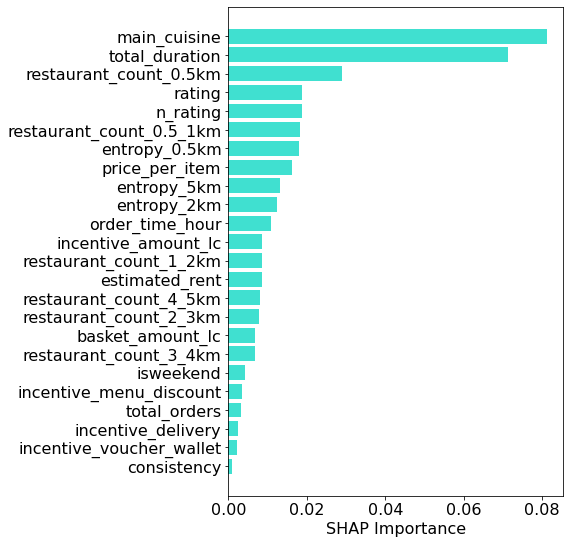

In [128]:
%%time
print(datetime.datetime.now(),'*************** Start running SHAP importance ***************')
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1,figsize=(6,9))
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center',color='turquoise')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.xlabel('SHAP Importance')
plt.savefig('./output/feature_importance_shap.pdf', bbox_inches='tight')
print(datetime.datetime.now(),'*************** Done running SHAP importance ***************')

In [43]:
# %%time
# # This is the visualization function offered by shap package for feature importance. ~1min
# print(datetime.datetime.now(),'*************** Start running SHAP importance ***************')
# #Plot the mean absolute value of the SHAP values
# fig_shapimportance = shap.plots.bar(shap_values, max_display=50,show=False)
# plt.savefig('./output/shap_importance.pdf', bbox_inches='tight')
# print(datetime.datetime.now(),'*************** Done running SHAP importance ***************')

2024-06-26 21:07:47.298805 *************** Start running beeswarm ***************
2024-06-26 21:15:43.836218 *************** Done running beeswarm ***************
CPU times: user 7min 46s, sys: 14.4 s, total: 8min
Wall time: 7min 56s


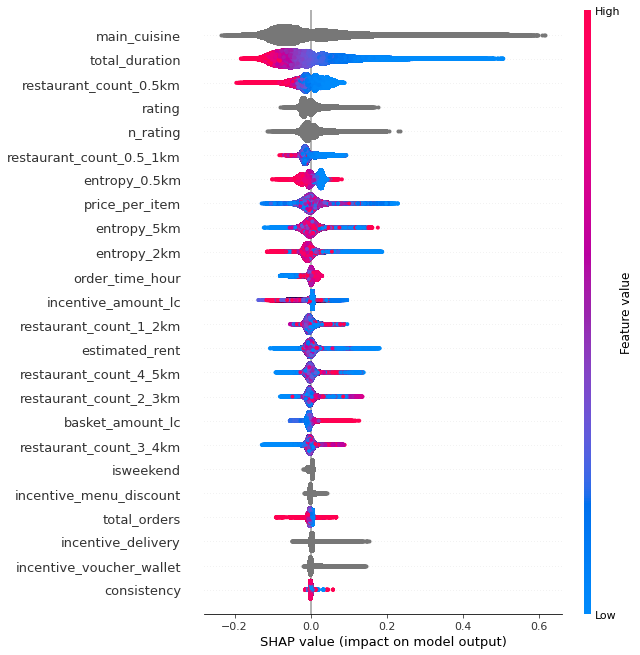

In [15]:
%%time
# ~6min
# Reading about gray colors: https://mlconference.ai/blog/tutorial-explainable-machine-learning-with-python-and-shap/
print(datetime.datetime.now(),'*************** Start running beeswarm ***************')
fig_beeswarm = shap.plots.beeswarm(shap_values,show=False, max_display=50)
plt.savefig('./output/shap_beeswarm_updated.pdf', bbox_inches='tight')
print(datetime.datetime.now(),'*************** Done running beeswarm ***************')

## Plot interaction effects between a pair

In [16]:
def plot_shap_interaction(var1, var2):
    fig = shap.dependence_plot(var1, shap_values.values, X, dot_size=5, alpha=0.4,
                           interaction_index=var2, show=False) #, ax=ax
    plt.savefig('./output/shap_' + var1 + '_' + var2 + '.pdf',bbox_inches='tight')

In [17]:
var_interact1 = 'restaurant_count_0.5km'
var_interact2 = 'entropy_0.5km'
var_interact3 = 'estimated_rent'

feature_list_continuous_for_shap = ['basket_amount_lc','price_per_item','order_time_hour','total_duration',
  'consistency', 'total_orders', 'entropy_2km', 'entropy_5km', 'restaurant_count_0.5km',
  'restaurant_count_0.5_1km', 'restaurant_count_1_2km', 'restaurant_count_2_3km', 'restaurant_count_3_4km',
  'restaurant_count_4_5km']

2024-06-26 21:28:37.151055 basket_amount_lc entropy_0.5km Running!!!
2024-06-26 21:29:00.128090 basket_amount_lc entropy_0.5km Done!!!
2024-06-26 21:29:00.128199 price_per_item entropy_0.5km Running!!!
2024-06-26 21:29:23.073992 price_per_item entropy_0.5km Done!!!
2024-06-26 21:29:23.074100 order_time_hour entropy_0.5km Running!!!
2024-06-26 21:29:45.150685 order_time_hour entropy_0.5km Done!!!
2024-06-26 21:29:45.150794 total_duration entropy_0.5km Running!!!
2024-06-26 21:30:07.243424 total_duration entropy_0.5km Done!!!
2024-06-26 21:30:07.243516 consistency entropy_0.5km Running!!!
2024-06-26 21:30:30.058629 consistency entropy_0.5km Done!!!
2024-06-26 21:30:30.058722 total_orders entropy_0.5km Running!!!
2024-06-26 21:30:51.872247 total_orders entropy_0.5km Done!!!
2024-06-26 21:30:51.872340 entropy_2km entropy_0.5km Running!!!
2024-06-26 21:31:14.937577 entropy_2km entropy_0.5km Done!!!
2024-06-26 21:31:14.937686 entropy_5km entropy_0.5km Running!!!
2024-06-26 21:31:37.810599 en

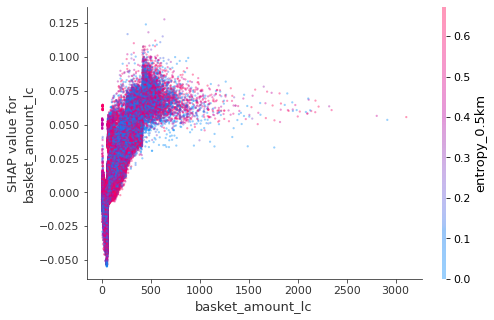

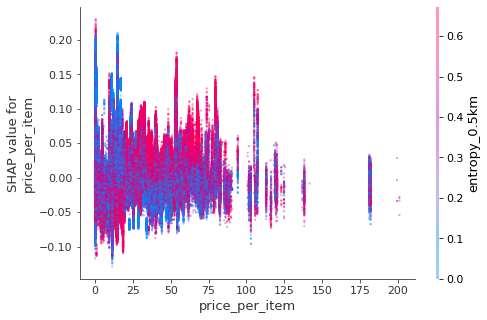

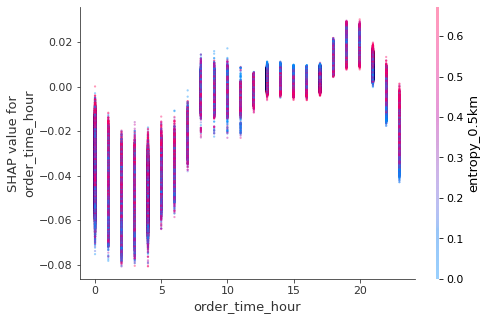

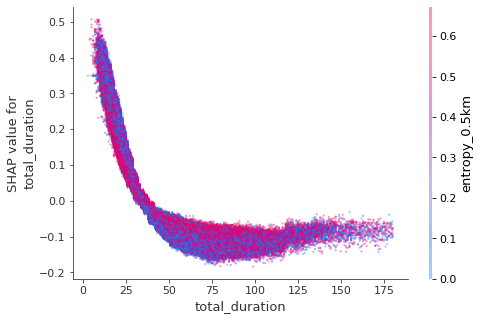

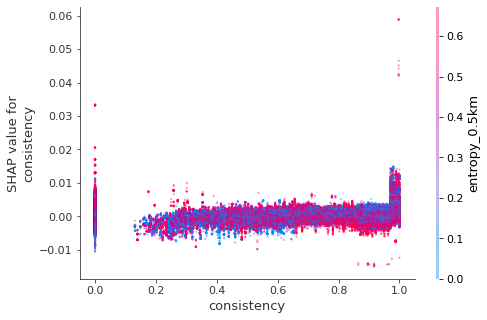

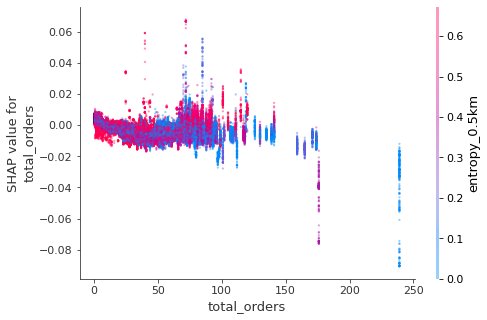

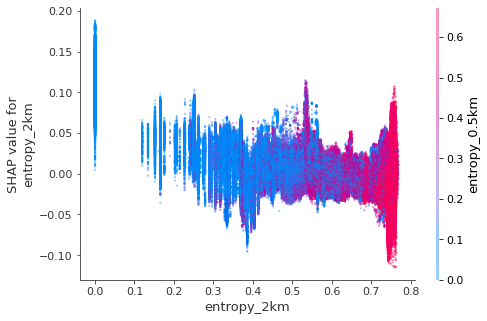

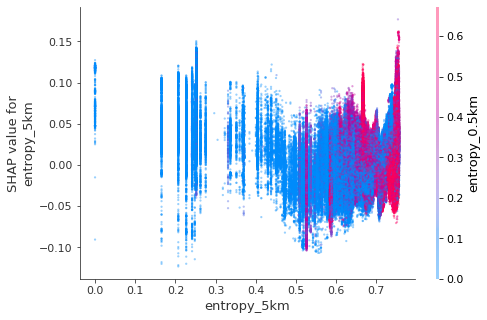

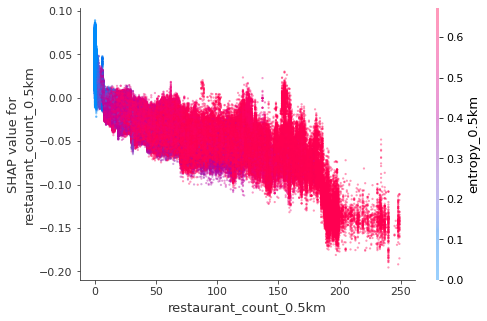

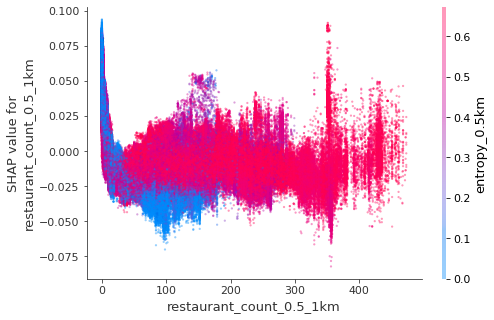

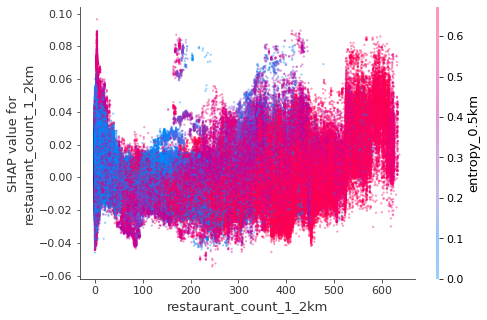

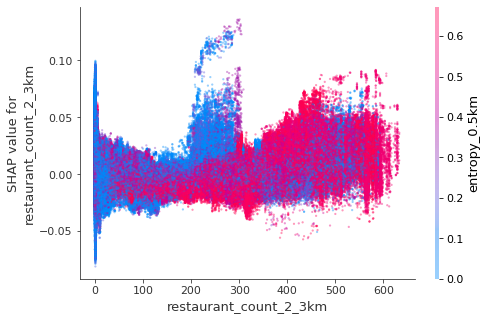

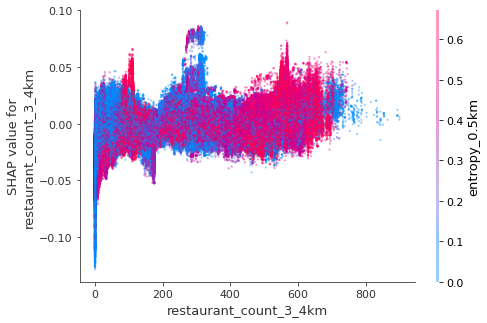

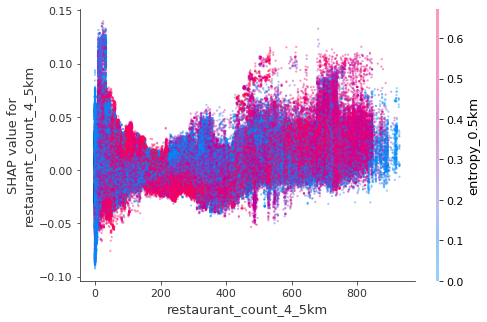

In [21]:
%%time
# ~12min interaction plot with var_interact2 = 'entropy_0.5km'
for var in feature_list_continuous_for_shap:
    print(datetime.datetime.now(), var, var_interact2,'Running!!!')
    plot_shap_interaction(var, var_interact2)
    print(datetime.datetime.now(), var, var_interact2,'Done!!!')

2024-06-26 21:35:24.930708 basket_amount_lc estimated_rent Running!!!
2024-06-26 21:35:47.639083 basket_amount_lc estimated_rent Done!!!
2024-06-26 21:35:47.639175 price_per_item estimated_rent Running!!!
2024-06-26 21:36:10.898991 price_per_item estimated_rent Done!!!
2024-06-26 21:36:10.899083 order_time_hour estimated_rent Running!!!
2024-06-26 21:36:33.198213 order_time_hour estimated_rent Done!!!
2024-06-26 21:36:33.198310 total_duration estimated_rent Running!!!
2024-06-26 21:36:55.495387 total_duration estimated_rent Done!!!
2024-06-26 21:36:55.495496 consistency estimated_rent Running!!!
2024-06-26 21:37:18.679132 consistency estimated_rent Done!!!
2024-06-26 21:37:18.679227 total_orders estimated_rent Running!!!
2024-06-26 21:37:41.085869 total_orders estimated_rent Done!!!
2024-06-26 21:37:41.086148 entropy_2km estimated_rent Running!!!
2024-06-26 21:38:04.588401 entropy_2km estimated_rent Done!!!
2024-06-26 21:38:04.588493 entropy_5km estimated_rent Running!!!
2024-06-26 21:

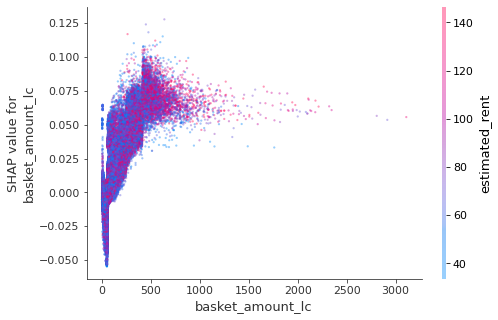

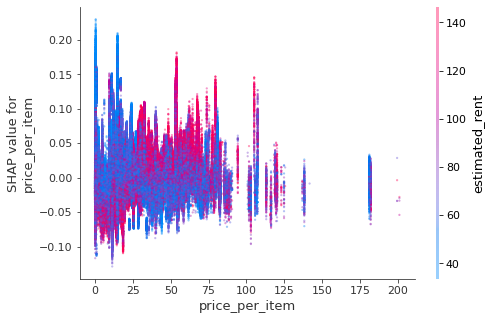

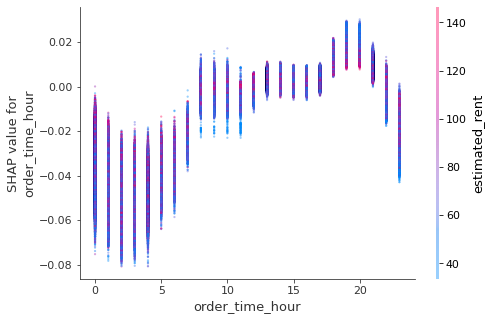

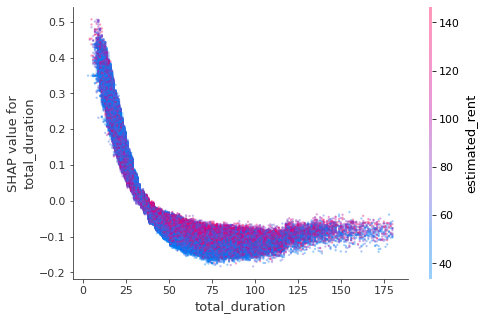

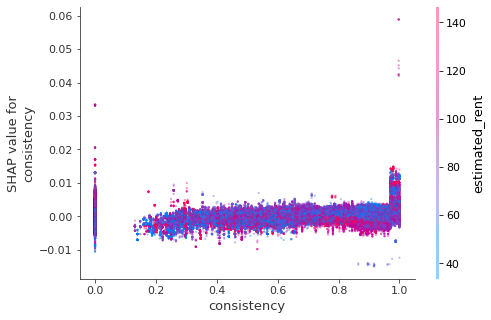

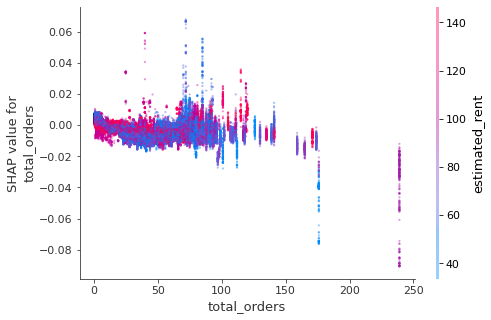

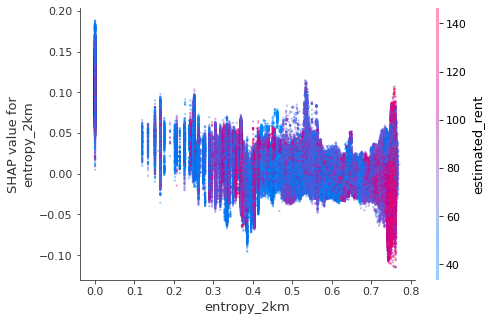

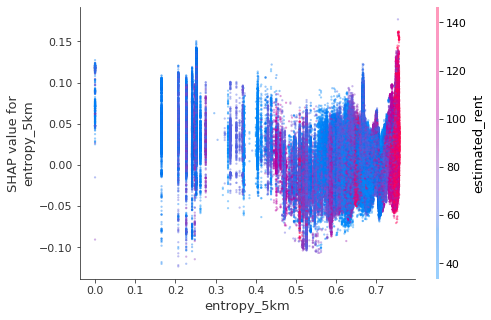

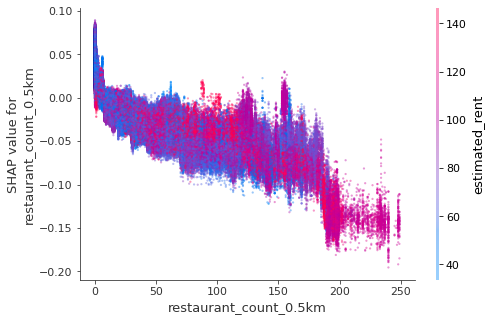

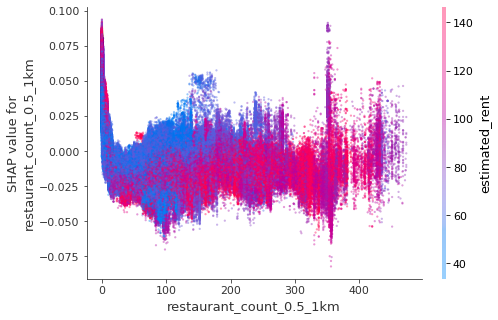

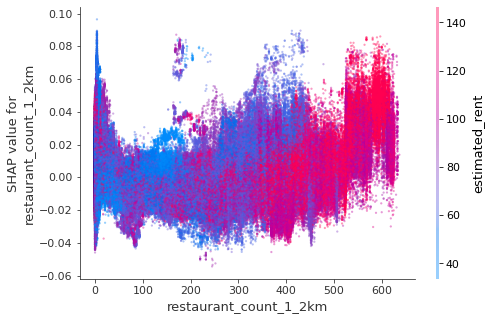

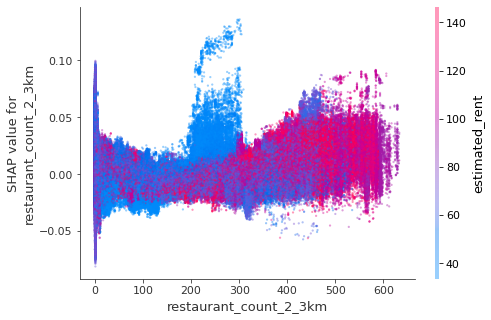

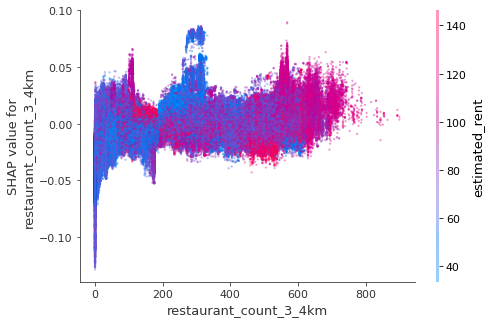

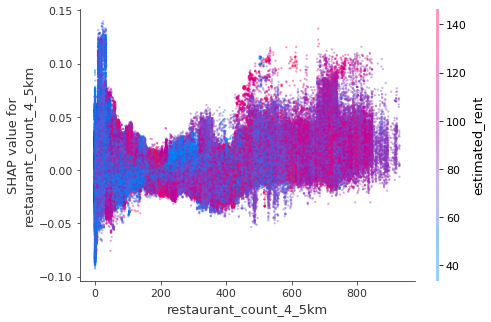

In [22]:
%%time
# ~12min interaction plot with var_interact3 = 'estimated_rent'
for var in feature_list_continuous_for_shap:
    print(datetime.datetime.now(), var, var_interact3,'Running!!!')
    plot_shap_interaction(var, var_interact3)
    print(datetime.datetime.now(), var, var_interact3,'Done!!!')

2024-06-26 21:42:13.671276 basket_amount_lc restaurant_count_0.5km Running!!!
2024-06-26 21:42:36.480732 basket_amount_lc restaurant_count_0.5km Done!!!
2024-06-26 21:42:36.480823 price_per_item restaurant_count_0.5km Running!!!
2024-06-26 21:42:59.457090 price_per_item restaurant_count_0.5km Done!!!
2024-06-26 21:42:59.457182 order_time_hour restaurant_count_0.5km Running!!!
2024-06-26 21:43:21.321909 order_time_hour restaurant_count_0.5km Done!!!
2024-06-26 21:43:21.322032 total_duration restaurant_count_0.5km Running!!!
2024-06-26 21:43:43.517658 total_duration restaurant_count_0.5km Done!!!
2024-06-26 21:43:43.517759 consistency restaurant_count_0.5km Running!!!
2024-06-26 21:44:06.720759 consistency restaurant_count_0.5km Done!!!
2024-06-26 21:44:06.720850 total_orders restaurant_count_0.5km Running!!!
2024-06-26 21:44:29.010455 total_orders restaurant_count_0.5km Done!!!
2024-06-26 21:44:29.010557 entropy_2km restaurant_count_0.5km Running!!!
2024-06-26 21:44:51.223283 entropy_2k

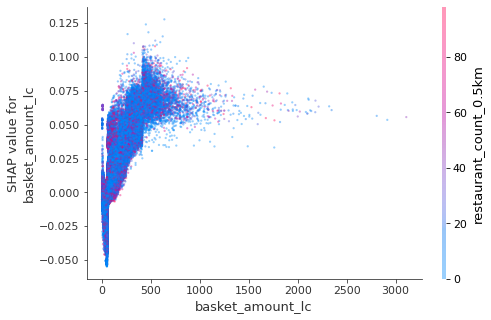

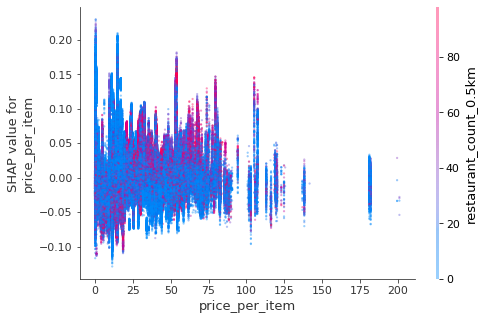

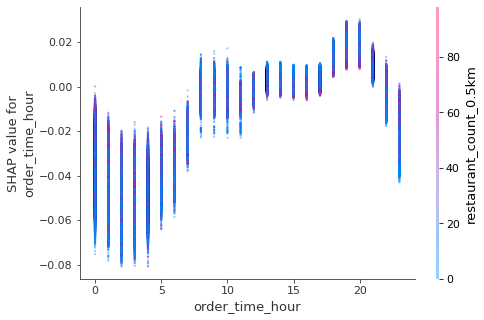

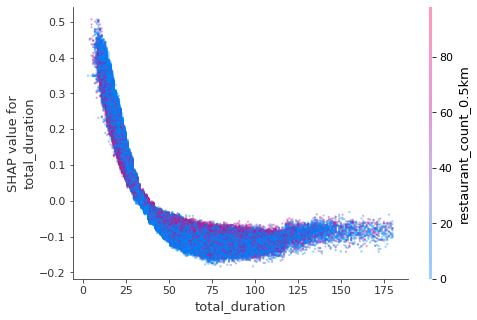

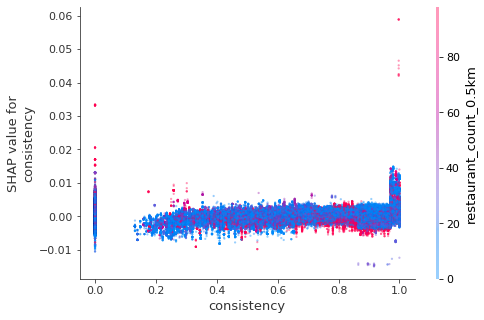

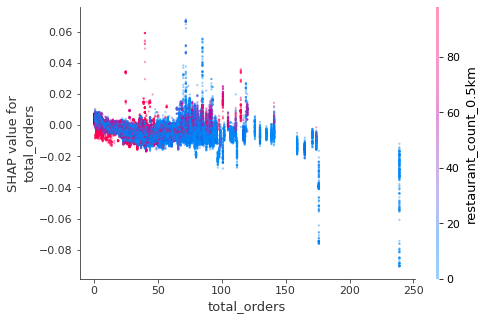

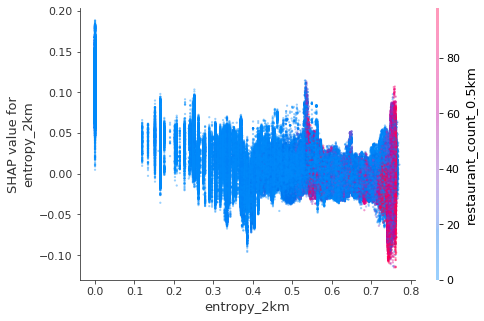

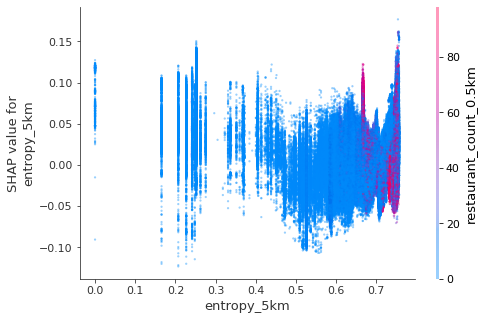

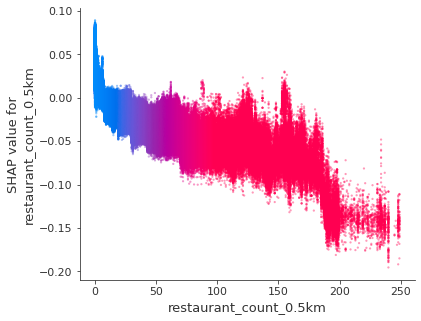

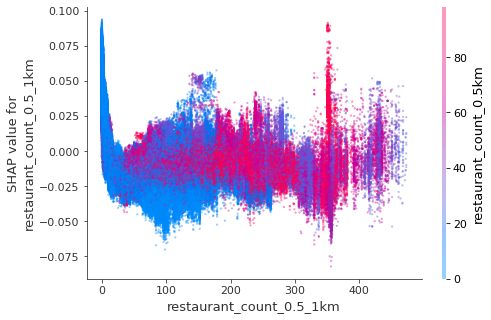

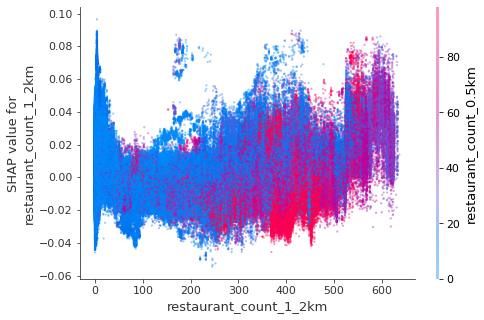

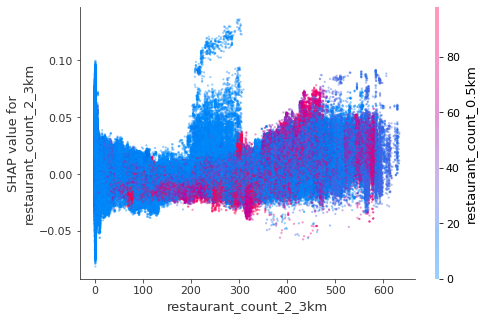

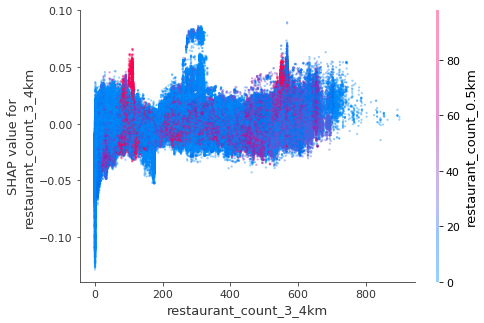

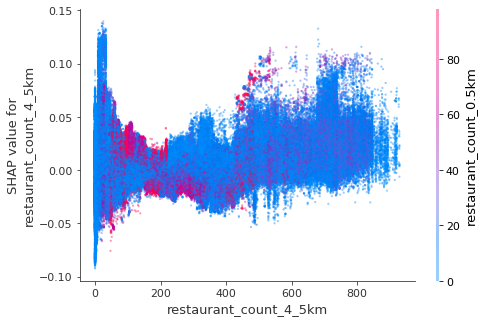

In [23]:
%%time
# ~12min interaction plot with var_interact1 = 'restaurant_count_0.5km'
for var in feature_list_continuous_for_shap:
    print(datetime.datetime.now(), var, var_interact1,'Running!!!')
    plot_shap_interaction(var, var_interact1)
    print(datetime.datetime.now(), var, var_interact1,'Done!!!')

CPU times: user 1min 3s, sys: 3.6 s, total: 1min 7s
Wall time: 1min 6s


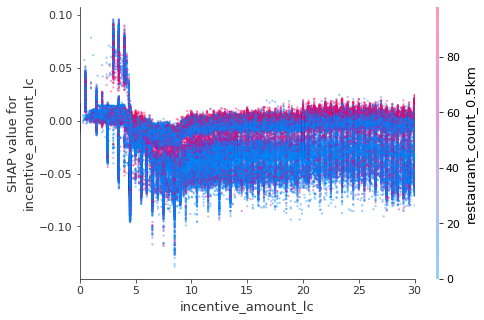

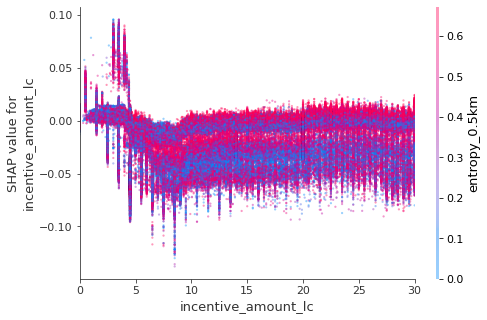

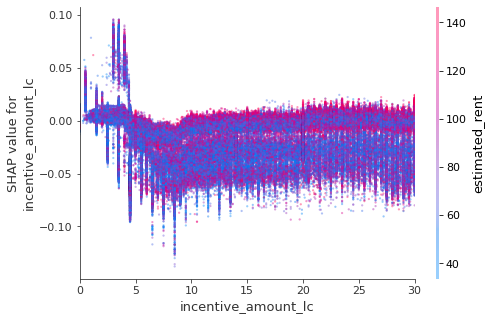

In [20]:
%%time

#for incentive we use this function because we need to modify the x axis range
def plot_shap_interaction_incentives(var1, x_jitter1=0):
    for var2 in [var_interact1, var_interact2, var_interact3]:
        fig_incentives = shap.dependence_plot(var1, shap_values.values, X, dot_size=5, alpha=0.4,
                               interaction_index=var2, show=False, x_jitter=x_jitter1)
        plt.xlim(xmin=0,xmax=30)
        plt.savefig('./output/shap_' + var1 + '_' + var2 + '.pdf',bbox_inches='tight')    
        
# set a x limit for incentive plots if needed, cancel the comment line in function plot_shap_interaction_onevar()
plot_shap_interaction_incentives('incentive_amount_lc')

In [18]:
# this function is for those categorical features that we need to add a bit jitter to prevent overlapping points
def plot_shap_interaction_onevar(var1, x_jitter1=0):
    for var2 in [var_interact1, var_interact2, var_interact3]:
        fig_incentives = shap.dependence_plot(var1, shap_values.values, X, dot_size=5, alpha=0.4,
                               interaction_index=var2, show=False, x_jitter=x_jitter1)
        plt.savefig('./output/shap_' + var1 + '_' + var2 + '.pdf',bbox_inches='tight')

print(feature_list_cat)

['isweekend', 'incentive_delivery', 'incentive_menu_discount', 'incentive_voucher_wallet', 'rating', 'n_rating']


CPU times: user 6min 55s, sys: 26.3 s, total: 7min 22s
Wall time: 7min 18s


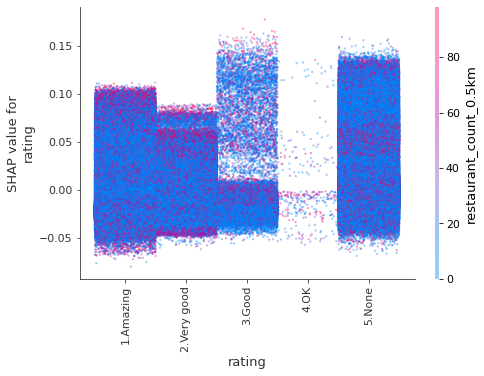

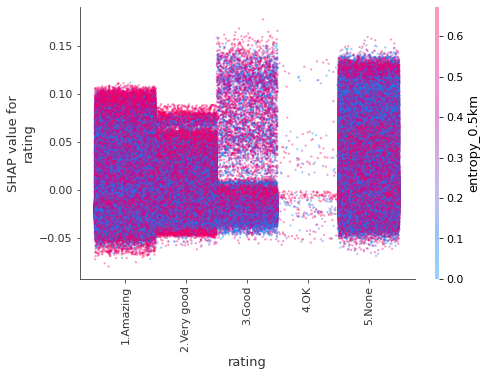

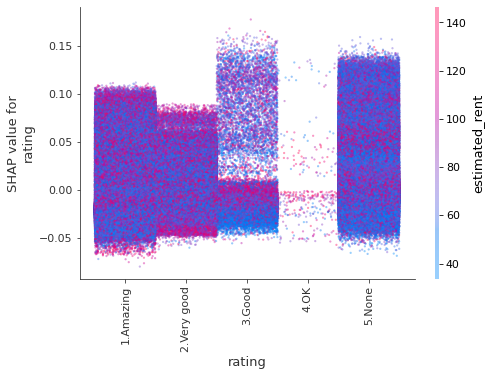

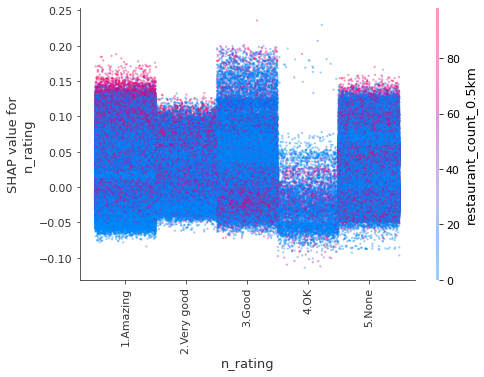

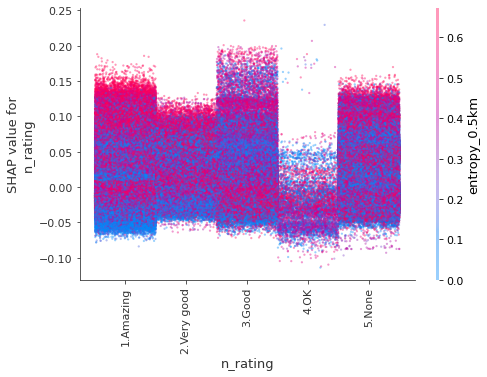

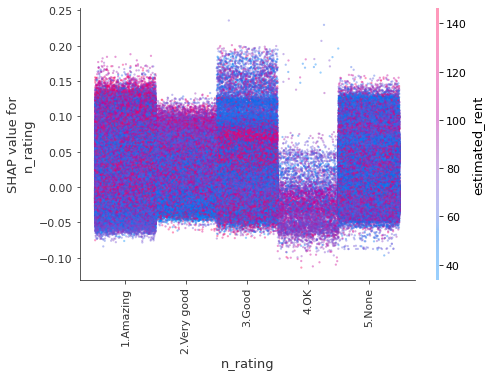

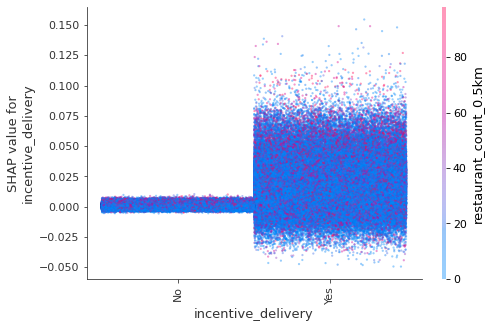

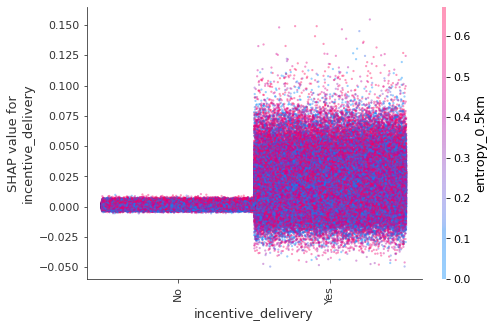

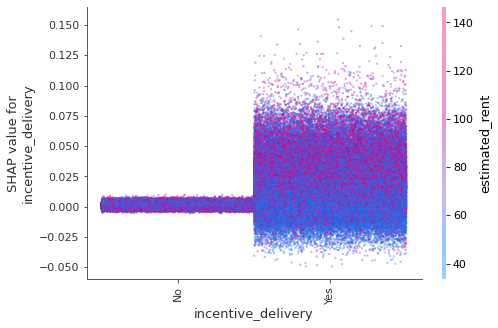

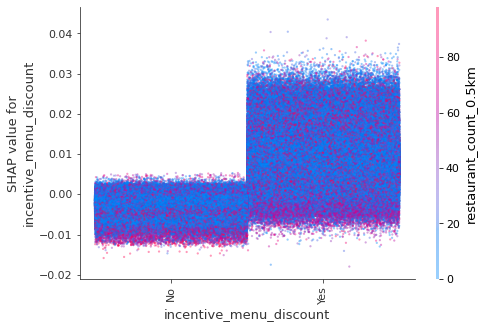

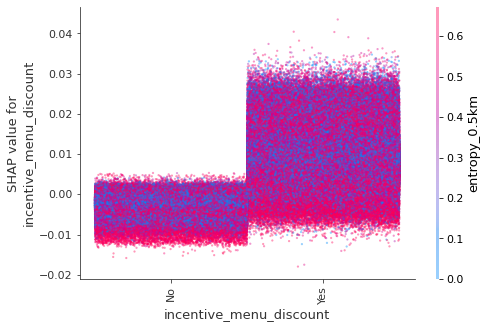

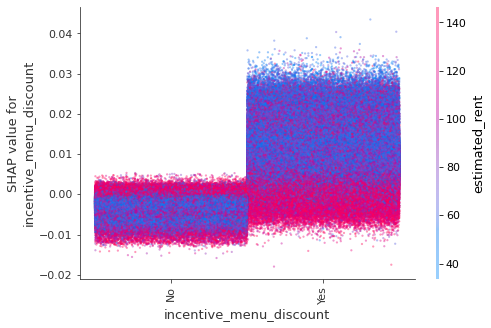

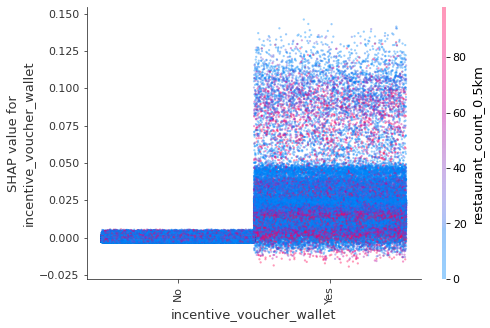

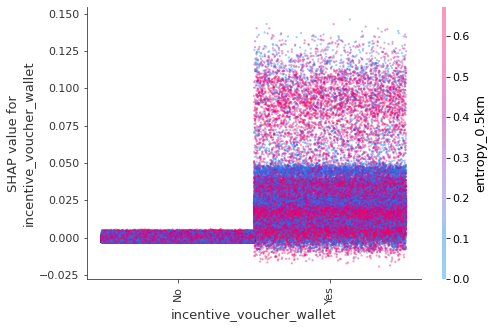

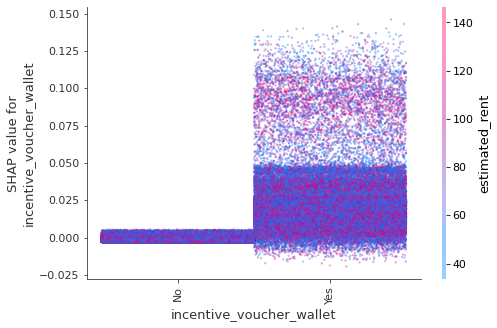

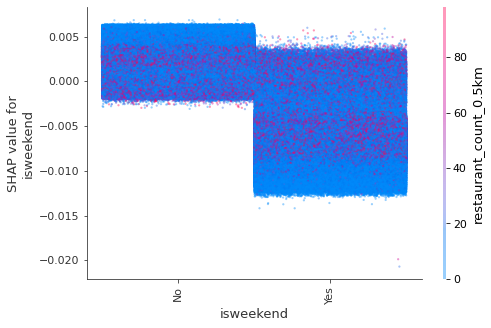

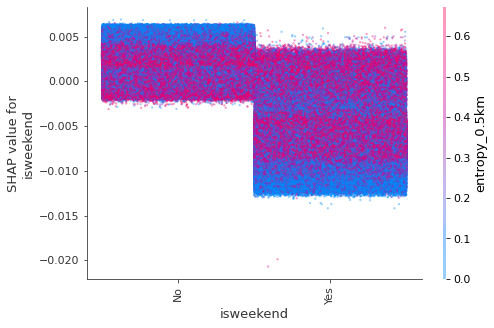

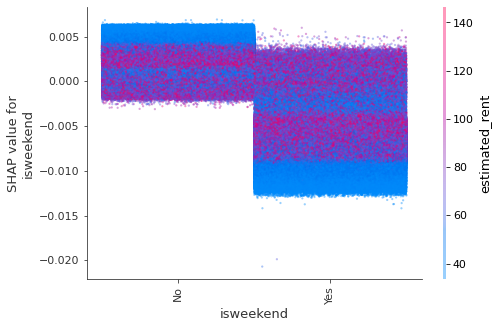

In [19]:
%%time
plot_shap_interaction_onevar('rating',x_jitter1=1)
plot_shap_interaction_onevar('n_rating',x_jitter1=1)
# plot_shap_interaction_onevar('order_time_hour',x_jitter1=1)
plot_shap_interaction_onevar('incentive_delivery',x_jitter1=1)
plot_shap_interaction_onevar('incentive_menu_discount',x_jitter1=1)
plot_shap_interaction_onevar('incentive_voucher_wallet',x_jitter1=1)
plot_shap_interaction_onevar('isweekend',x_jitter1=1)

## (Optional step) Most important interaction effects

In [ ]:
%%time
shap.dependence_plot(0, shap_values.values, X)
# interaction_index“auto”, pick the strongest interaction
# basket amount has a bigger effect on shorter duration orders than on longer duration orders

In [ ]:
%%time
shap.dependence_plot(1, shap_values.values, X)